# Genetic Slope Training: Nokappa v3 + Time-Dependent Genetic Effects

Extends the nokappa v3 reparameterization with genetic slopes:

$$\lambda_{ik}(t) = \text{sig\_ref}_k + s \cdot (\mathbf{g}_i^\top \gamma_{\text{level},k}) + t \cdot s \cdot (\mathbf{g}_i^\top \gamma_{\text{slope},k}) + \delta_{ik}(t)$$

**Two-phase training** (from `genetic_slope_recovery.ipynb`):
1. **Phase 1**: $\delta$ frozen. $\gamma_{\text{slope}}$ must learn from NLL gradient.
2. **Phase 2**: $\delta$ unfrozen. All params fine-tune.

Warm-starts from trained nokappa v3 checkpoint (batch 0, 10k patients).

In [ ]:
import numpy as np
import pandas as pd
import torch
import os, sys, gc, time, glob
from pathlib import Path
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

sys.path.insert(0, '/Users/sarahurbut/aladynoulli2/claudefile')
from clust_huge_amp_vectorized_reparam_slope import AladynSurvivalReparamWithSlope, subset_data

DATA_DIR = Path('/Users/sarahurbut/Library/CloudStorage/Dropbox-Personal/data_for_running/')
CKPT_DIR = Path('/Users/sarahurbut/Library/CloudStorage/Dropbox/censor_e_batchrun_vectorized_REPARAM_v3_nokappa/')
COV_PATH = '/Users/sarahurbut/Library/CloudStorage/Dropbox-Personal/baselinagefamh_withpcs.csv'

print('Ready.')

Ready.


## 1. Load data and checkpoint

In [ ]:
# Load data
Y = torch.load(DATA_DIR / 'Y_tensor.pt', weights_only=False)
E = torch.load(DATA_DIR / 'E_matrix_corrected.pt', weights_only=False)
G_prs = torch.load(DATA_DIR / 'G_matrix.pt', weights_only=False)  # 36 PRS scores
essentials = torch.load(DATA_DIR / 'model_essentials.pt', weights_only=False)
refs = torch.load(DATA_DIR / 'reference_trajectories.pt', weights_only=False)
disease_names = essentials['disease_names']
prevalence_t = torch.load(DATA_DIR / 'prevalence_t_corrected.pt', weights_only=False)
signature_refs = refs['signature_refs']

# Build G_with_sex: 36 PRS + sex + 10 PCs = 47 features
fh = pd.read_csv(COV_PATH)
sex = fh['sex'].values
pc_cols = [f'f.22009.0.{i}' for i in range(1, 11)]
pcs = fh[pc_cols].values
G_full = np.column_stack([G_prs, sex, pcs])

print(f'Y: {Y.shape}, E: {E.shape}')
print(f'G_prs: {G_prs.shape} -> G_full: {G_full.shape} (PRS + sex + PCs)')
print(f'{len(disease_names)} diseases, {len(signature_refs)} signatures')

Y: torch.Size([407878, 348, 52]), E: torch.Size([407878, 348])
G_prs: torch.Size([407878, 36]) -> G_full: (407878, 47) (PRS + sex + PCs)
348 diseases, 20 signatures


In [ ]:
# Subset to batch 0 (first 10k) for initial test
BATCH = 0
BATCH_SIZE = 10000
start = BATCH * BATCH_SIZE
stop = start + BATCH_SIZE

Y_batch, E_batch, G_batch, indices = subset_data(Y, E, G_full, start, stop)
N, D, T = Y_batch.shape
K = len(signature_refs)
P = G_batch.shape[1]
print(f'Batch {BATCH}: N={N}, D={D}, T={T}, K={K}, P={P}')

Batch 0: N=10000, D=348, T=52, K=20, P=47


In [ ]:
# Load the nokappa v3 checkpoint for this batch
ckpt_files = sorted(glob.glob(str(CKPT_DIR / '*_0_10000.pt')))
print(f'Found {len(ckpt_files)} checkpoint files matching batch 0')

if ckpt_files:
    ckpt = torch.load(ckpt_files[0], weights_only=False)
    print(f'Loaded: {ckpt_files[0]}')
    print(f'Keys: {list(ckpt.keys()) if isinstance(ckpt, dict) else type(ckpt)}')
    
    # gamma and psi are top-level; delta and epsilon are in model_state_dict
    pretrained_gamma = ckpt['gamma']
    pretrained_psi = ckpt['psi']
    sd = ckpt['model_state_dict']
    pretrained_delta = sd['delta']
    pretrained_epsilon = sd['epsilon']
    
    print(f'  gamma:   {pretrained_gamma.shape}')
    print(f'  psi:     {pretrained_psi.shape}')
    print(f'  delta:   {pretrained_delta.shape}')
    print(f'  epsilon: {pretrained_epsilon.shape}')
    print(f'  losses:  {len(ckpt["losses"])} epochs, final={ckpt["losses"][-1]:.2f}')

Found 1 checkpoint files matching batch 0
Loaded: /Users/sarahurbut/Library/CloudStorage/Dropbox/censor_e_batchrun_vectorized_REPARAM_v3_nokappa/enrollment_model_REPARAM_NOKAPPA_W0.0001_batch_0_10000.pt
Keys: ['model_state_dict', 'phi', 'psi', 'gamma', 'kappa', 'Y', 'prevalence_t', 'logit_prevalence_t', 'G', 'args', 'indices', 'clusters', 'losses', 'version']
  gamma:   torch.Size([47, 21])
  psi:     torch.Size([21, 348])
  delta:   torch.Size([10000, 21, 52])
  epsilon: torch.Size([21, 348, 52])
  losses:  300 epochs, final=46.23


## 2. Build slope model and train

In [ ]:
torch.manual_seed(42)
np.random.seed(42)

model = AladynSurvivalReparamWithSlope(
    N=N, D=D, T=T, K=K, P=P,
    G=G_batch, Y=Y_batch,
    R=0, W=0.0001,
    prevalence_t=prevalence_t,
    init_sd_scaler=1e-1, genetic_scale=1,
    signature_references=signature_refs,
    healthy_reference=True,
    disease_names=disease_names,
    pretrained_gamma=pretrained_gamma,
    pretrained_psi=pretrained_psi,
    pretrained_delta=pretrained_delta,
    pretrained_epsilon=pretrained_epsilon,
)

print(f'\nTotal parameters: {sum(p.numel() for p in model.parameters()):,}')
print(f'  gamma_level: {model.gamma_level.numel():,}')
print(f'  gamma_slope: {model.gamma_slope.numel():,}')
print(f'  delta:       {model.delta.numel():,}')
print(f'  psi:         {model.psi.numel():,}')
print(f'  epsilon:     {model.epsilon.numel():,}')

Warm-starting from pretrained gamma (torch.Size([47, 21])), psi (torch.Size([21, 348]))
Slope model init: gamma_level torch.Size([47, 21]), gamma_slope torch.Size([47, 21]) (zeros), delta torch.Size([10000, 21, 52]), epsilon torch.Size([21, 348, 52])

Total parameters: 11,309,298
  gamma_level: 987
  gamma_slope: 987
  delta:       10,920,000
  psi:         7,308
  epsilon:     380,016


In [ ]:
# Two-phase training
t0 = time.time()
history = model.fit_two_phase(
    event_times=E_batch,
    num_epochs_phase1=100,
    num_epochs_phase2=200,
    learning_rate=0.1,
    lr_slope=0.1,
    verbose_every=20,
)
elapsed = time.time() - t0
print(f'\nTotal training time: {elapsed:.0f}s ({elapsed/60:.1f} min)')

PHASE 1: delta frozen, learning gamma_slope (100 epochs)
  P1 Epoch    0: loss=46.18, NLL=53.10, |gamma_slope|=3.0659
  P1 Epoch   20: loss=46.50, NLL=45.79, |gamma_slope|=2.6342
  P1 Epoch   40: loss=45.77, NLL=45.31, |gamma_slope|=3.3426
  P1 Epoch   60: loss=45.50, NLL=45.06, |gamma_slope|=4.2235
  P1 Epoch   80: loss=45.33, NLL=44.90, |gamma_slope|=5.0590
  P1 Epoch   99: loss=45.21, NLL=44.78, |gamma_slope|=5.7677

PHASE 2: delta unfrozen, all params train (200 epochs)
  P2 Epoch    0: loss=45.21, NLL=48.41, |gamma_slope|=5.8389
  P2 Epoch   20: loss=67.19, NLL=43.95, |gamma_slope|=5.9097
  P2 Epoch   40: loss=46.34, NLL=43.31, |gamma_slope|=5.9709
  P2 Epoch   60: loss=43.71, NLL=42.81, |gamma_slope|=6.0484
  P2 Epoch   80: loss=42.93, NLL=42.34, |gamma_slope|=6.1292
  P2 Epoch  100: loss=42.47, NLL=41.90, |gamma_slope|=6.2107
  P2 Epoch  120: loss=42.07, NLL=41.48, |gamma_slope|=6.2928
  P2 Epoch  140: loss=41.70, NLL=41.09, |gamma_slope|=6.3773
  P2 Epoch  160: loss=41.35, NLL=

## 3. Diagnostics

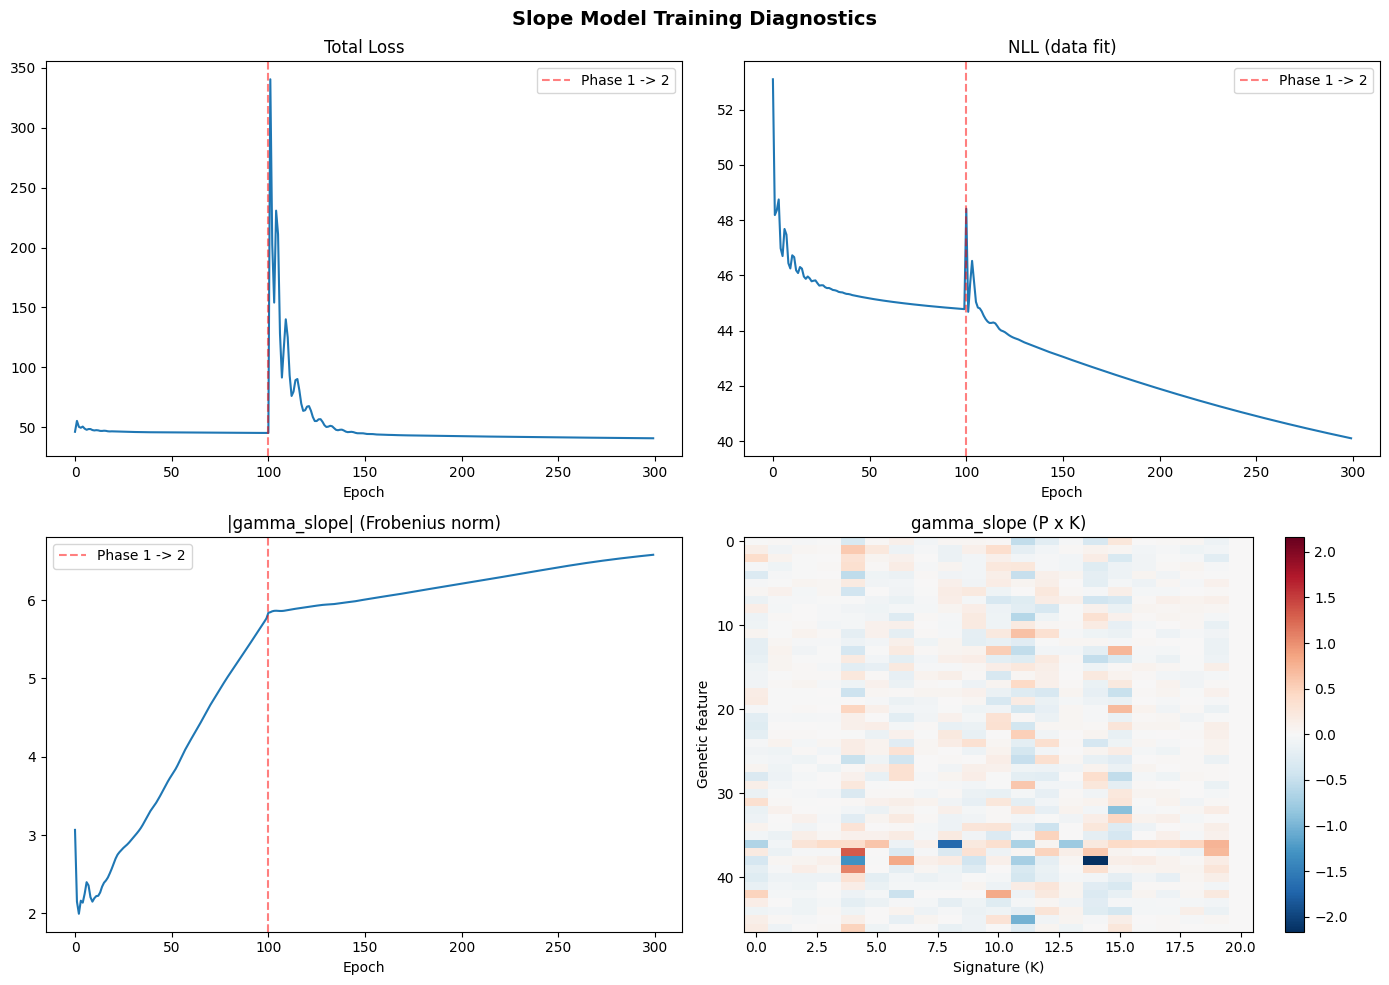

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Loss curves
p1_len = len(history['phase1_losses'])
all_losses = history['phase1_losses'] + history['phase2_losses']
axes[0, 0].plot(all_losses)
axes[0, 0].axvline(p1_len, color='red', ls='--', alpha=0.5, label='Phase 1 -> 2')
axes[0, 0].set_title('Total Loss')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].legend()

# NLL
all_nll = history['phase1_nll'] + history['phase2_nll']
axes[0, 1].plot(all_nll)
axes[0, 1].axvline(p1_len, color='red', ls='--', alpha=0.5, label='Phase 1 -> 2')
axes[0, 1].set_title('NLL (data fit)')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].legend()

# gamma_slope norm over training
axes[1, 0].plot(history['gamma_slope_norm'])
axes[1, 0].axvline(p1_len, color='red', ls='--', alpha=0.5, label='Phase 1 -> 2')
axes[1, 0].set_title('|gamma_slope| (Frobenius norm)')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].legend()

# gamma_slope heatmap
gs = model.gamma_slope.data.numpy()
im = axes[1, 1].imshow(gs, aspect='auto', cmap='RdBu_r', vmin=-np.abs(gs).max(), vmax=np.abs(gs).max())
axes[1, 1].set_title('gamma_slope (P x K)')
axes[1, 1].set_xlabel('Signature (K)')
axes[1, 1].set_ylabel('Genetic feature')
plt.colorbar(im, ax=axes[1, 1])

plt.suptitle('Slope Model Training Diagnostics', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

In [ ]:
# Top genetic slope features per signature
prs_df = pd.read_csv('/Users/sarahurbut/aladynoulli2/prs_names.csv')
prs_names = list(prs_df.columns) + list(prs_df.iloc[:, 0].values)
prs_names_full = prs_names + ['Sex'] + [f'PC{i}' for i in range(1, 11)]
gs = model.gamma_slope.data.numpy()
gl = model.gamma_level.data.numpy()

print('TOP GENETIC SLOPE FEATURES (|gamma_slope| per signature):')
print('='*70)
for k in range(model.K):
    slopes_k = gs[:, k]
    top_idx = np.argsort(np.abs(slopes_k))[::-1][:5]
    print(f'\nSignature {k}:')
    for i in top_idx:
        name = prs_names_full[i] if i < len(prs_names_full) else f'feat_{i}'
        print(f'  {name:30s}  level={gl[i,k]:+.4f}  slope={slopes_k[i]:+.4f}')

print(f'\n|gamma_slope| overall: {np.abs(gs).mean():.5f}')
print(f'|gamma_level| overall: {np.abs(gl).mean():.5f}')
print(f'Ratio slope/level: {np.abs(gs).mean() / (np.abs(gl).mean() + 1e-8):.4f}')

TOP GENETIC SLOPE FEATURES (|gamma_slope| per signature):

Signature 0:
  Sex                             level=+1.1678  slope=-0.6570
  PC6                             level=-0.4338  slope=+0.4857
  AD                              level=-0.3595  slope=+0.3723
  PC2                             level=+0.4046  slope=-0.3654
  SLE                             level=-0.4011  slope=+0.3458

Signature 1:
  VTE                             level=+0.1819  slope=-0.1312
  PC1                             level=+0.2759  slope=-0.1260
  PC4                             level=-0.0847  slope=-0.1174
  PSO                             level=+0.1302  slope=-0.1110
  PC10                            level=+0.2048  slope=-0.1029

Signature 2:
  Sex                             level=+0.1493  slope=+0.2781
  PC3                             level=+0.0246  slope=+0.1469
  VTE                             level=+0.0471  slope=+0.1270
  PC4                             level=-0.0943  slope=-0.1096
  PC5             

In [ ]:
# Save checkpoint
OUTPUT_DIR = Path('/Users/sarahurbut/Library/CloudStorage/Dropbox/slope_model_nokappa_v3/')
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

ckpt_save = {
    'gamma_level': model.gamma_level.data.clone(),
    'gamma_slope': model.gamma_slope.data.clone(),
    'gamma_health': model.gamma_health.clone(),  # health anchor weights (fixed)
    'psi': model.psi.data.clone(),
    'delta': model.delta.data.clone(),
    'epsilon': model.epsilon.data.clone(),
    'history': history,
    'config': {'N': N, 'D': D, 'T': T, 'K': K, 'P': P,
               'batch': BATCH, 'start': start, 'stop': stop,
               'W': 0.0001, 'lr': 0.1,
               'phase1_epochs': 100, 'phase2_epochs': 200},
}
save_path = OUTPUT_DIR / f'slope_model_batch_{start}_{stop}.pt'
torch.save(ckpt_save, save_path)
print(f'Saved: {save_path}')

Saved: /Users/sarahurbut/Library/CloudStorage/Dropbox/slope_model_nokappa_v3/slope_model_batch_0_10000.pt


## 4. Holdout Evaluation: Slope vs No-Slope

Compare holdout NLL on batch 1 (10k-20k) using:
- **Slope model**: gamma_level + gamma_slope from this training
- **No-slope (nokappa v3)**: gamma from the original checkpoint

Both fix population params and fit only delta on the holdout batch.

In [ ]:
# Holdout batch
HOLDOUT_BATCH = 1
h_start = HOLDOUT_BATCH * BATCH_SIZE
h_stop = h_start + BATCH_SIZE
Y_hold, E_hold, G_hold, _ = subset_data(Y, E, G_full, h_start, h_stop)
N_h = Y_hold.shape[0]
print(f'Holdout batch {HOLDOUT_BATCH}: {h_start}-{h_stop}, N={N_h}')

# --- Slope model on holdout ---
print('\n--- Fitting SLOPE model on holdout ---')
torch.manual_seed(42); np.random.seed(42)
model_slope_hold = AladynSurvivalReparamWithSlope(
    N=N_h, D=D, T=T, K=K, P=P,
    G=G_hold, Y=Y_hold,
    R=0, W=0.0001,
    prevalence_t=prevalence_t,
    init_sd_scaler=1e-1, genetic_scale=1,
    signature_references=signature_refs,
    healthy_reference=True,
    disease_names=disease_names,
    pretrained_gamma=model.gamma_level.data.clone(),
    pretrained_psi=model.psi.data.clone(),
    gamma_health=model.gamma_health,  # person-specific health anchor
    # delta/epsilon NOT passed — will init to zeros, then fit
)
# Fix population params, only fit delta
model_slope_hold.gamma_level.requires_grad_(False)
model_slope_hold.gamma_slope.requires_grad_(False)
model_slope_hold.psi.requires_grad_(False)
model_slope_hold.epsilon.requires_grad_(False)
# Copy the learned slopes
model_slope_hold.gamma_slope.data = model.gamma_slope.data.clone()

opt_s = torch.optim.Adam([model_slope_hold.delta], lr=0.1)
slope_losses, slope_nlls = [], []
for ep in range(200):
    opt_s.zero_grad()
    loss = model_slope_hold.compute_loss(E_hold)
    loss.backward()
    opt_s.step()
    with torch.no_grad():
        nll = model_slope_hold.compute_nll_only(E_hold).item()
    slope_losses.append(loss.item())
    slope_nlls.append(nll)
    if ep % 50 == 0: print(f'  Epoch {ep}: loss={loss.item():.2f}, NLL={nll:.2f}')
print(f'  Final: loss={slope_losses[-1]:.2f}, NLL={slope_nlls[-1]:.2f}')

# --- No-slope (standard nokappa v3) on holdout ---
print('\n--- Fitting NO-SLOPE model on holdout ---')
torch.manual_seed(42); np.random.seed(42)
model_noslope_hold = AladynSurvivalReparamWithSlope(
    N=N_h, D=D, T=T, K=K, P=P,
    G=G_hold, Y=Y_hold,
    R=0, W=0.0001,
    prevalence_t=prevalence_t,
    init_sd_scaler=1e-1, genetic_scale=1,
    signature_references=signature_refs,
    healthy_reference=True,
    disease_names=disease_names,
    pretrained_gamma=pretrained_gamma,  # original nokappa v3 gamma
    pretrained_psi=pretrained_psi,      # original nokappa v3 psi
    gamma_health=model.gamma_health,    # same health anchor for fair comparison
)
# gamma_slope stays at zero (no slopes)
model_noslope_hold.gamma_level.requires_grad_(False)
model_noslope_hold.gamma_slope.requires_grad_(False)
model_noslope_hold.psi.requires_grad_(False)
model_noslope_hold.epsilon.requires_grad_(False)

opt_ns = torch.optim.Adam([model_noslope_hold.delta], lr=0.1)
noslope_losses, noslope_nlls = [], []
for ep in range(200):
    opt_ns.zero_grad()
    loss = model_noslope_hold.compute_loss(E_hold)
    loss.backward()
    opt_ns.step()
    with torch.no_grad():
        nll = model_noslope_hold.compute_nll_only(E_hold).item()
    noslope_losses.append(loss.item())
    noslope_nlls.append(nll)
    if ep % 50 == 0: print(f'  Epoch {ep}: loss={loss.item():.2f}, NLL={nll:.2f}')
print(f'  Final: loss={noslope_losses[-1]:.2f}, NLL={noslope_nlls[-1]:.2f}')

print(f'\n{"="*60}')
print(f'HOLDOUT NLL COMPARISON (batch {HOLDOUT_BATCH}, {N_h} patients)')
print(f'  Slope model:    NLL = {slope_nlls[-1]:.4f}')
print(f'  No-slope model: NLL = {noslope_nlls[-1]:.4f}')
print(f'  Improvement:    {noslope_nlls[-1] - slope_nlls[-1]:.4f} ({(noslope_nlls[-1] - slope_nlls[-1])/noslope_nlls[-1]*100:.2f}%)')
print(f'{"="*60}')

Holdout batch 1: 10000-20000, N=10000

--- Fitting SLOPE model on holdout ---
Warm-starting from pretrained gamma (torch.Size([47, 21])), psi (torch.Size([21, 348]))
Slope model init: gamma_level torch.Size([47, 21]), gamma_slope torch.Size([47, 21]) (zeros), delta torch.Size([10000, 21, 52]), epsilon torch.Size([21, 348, 52])
  Epoch 0: loss=67.02, NLL=65.36
  Epoch 50: loss=57.86, NLL=56.48
  Epoch 100: loss=50.04, NLL=49.46
  Epoch 150: loss=46.47, NLL=45.90
  Final: loss=44.54, NLL=43.95

--- Fitting NO-SLOPE model on holdout ---
Warm-starting from pretrained gamma (torch.Size([47, 21])), psi (torch.Size([21, 348]))
Slope model init: gamma_level torch.Size([47, 21]), gamma_slope torch.Size([47, 21]) (zeros), delta torch.Size([10000, 21, 52]), epsilon torch.Size([21, 348, 52])
  Epoch 0: loss=63.20, NLL=61.79
  Epoch 50: loss=58.79, NLL=57.64
  Epoch 100: loss=53.60, NLL=53.22
  Epoch 150: loss=50.73, NLL=50.32
  Final: loss=48.93, NLL=48.49

HOLDOUT NLL COMPARISON (batch 1, 10000 p

## 5. Slope Visualizations

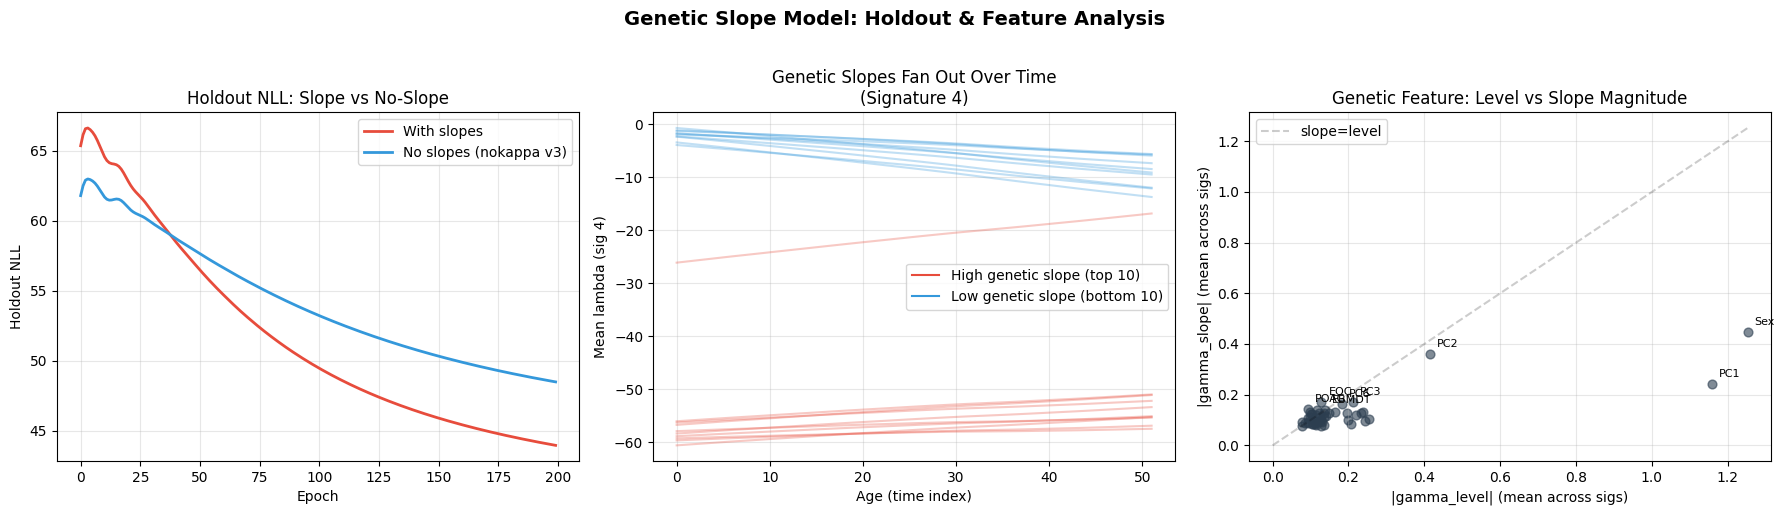

Saved: slope_holdout_analysis.pdf


In [ ]:
# --- Plot 1: Holdout NLL convergence comparison ---
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

ax = axes[0]
ax.plot(slope_nlls, label='With slopes', color='#e74c3c', linewidth=2)
ax.plot(noslope_nlls, label='No slopes (nokappa v3)', color='#3498db', linewidth=2)
ax.set_xlabel('Epoch'); ax.set_ylabel('Holdout NLL')
ax.set_title('Holdout NLL: Slope vs No-Slope')
ax.legend(); ax.grid(alpha=0.3)

# --- Plot 2: Mean lambda trajectories for high-slope vs low-slope individuals ---
ax = axes[1]
with torch.no_grad():
    mean_lam_slope = model_slope_hold.get_mean_lambda()
    mean_lam_noslope = model_noslope_hold.get_mean_lambda()

# Pick signature with largest slope effect
slope_effect_per_k = (mean_lam_slope - mean_lam_noslope).abs().mean(dim=(0, 2))
best_k = slope_effect_per_k[:K].argmax().item()

# Find high-slope and low-slope individuals for that signature
slope_scores = (G_hold @ model.gamma_slope.data[:, best_k].numpy()).flatten()
top_10 = np.argsort(slope_scores)[-10:]
bot_10 = np.argsort(slope_scores)[:10]

t_axis = np.arange(T)
for i in top_10:
    ax.plot(t_axis, mean_lam_slope[i, best_k, :].numpy(), color='#e74c3c', alpha=0.3)
for i in bot_10:
    ax.plot(t_axis, mean_lam_slope[i, best_k, :].numpy(), color='#3498db', alpha=0.3)
ax.plot([], [], color='#e74c3c', label='High genetic slope (top 10)')
ax.plot([], [], color='#3498db', label='Low genetic slope (bottom 10)')
ax.set_xlabel('Age (time index)'); ax.set_ylabel(f'Mean lambda (sig {best_k})')
ax.set_title(f'Genetic Slopes Fan Out Over Time\n(Signature {best_k})')
ax.legend(); ax.grid(alpha=0.3)

# --- Plot 3: Slope vs level scatter for top PRS features ---
ax = axes[2]
gs = model.gamma_slope.data.numpy()
gl = model.gamma_level.data.numpy()
# Average across signatures
avg_slope = np.abs(gs[:len(prs_names_full), :K]).mean(axis=1)
avg_level = np.abs(gl[:len(prs_names_full), :K]).mean(axis=1)

ax.scatter(avg_level, avg_slope, s=40, alpha=0.6, c='#2c3e50')
# Label top features
top_features = np.argsort(avg_slope)[::-1][:8]
for idx in top_features:
    name = prs_names_full[idx] if idx < len(prs_names_full) else f'f{idx}'
    ax.annotate(name, (avg_level[idx], avg_slope[idx]), fontsize=8,
               xytext=(5, 5), textcoords='offset points')
ax.set_xlabel('|gamma_level| (mean across sigs)')
ax.set_ylabel('|gamma_slope| (mean across sigs)')
ax.set_title('Genetic Feature: Level vs Slope Magnitude')
ax.plot([0, avg_level.max()], [0, avg_level.max()], 'k--', alpha=0.2, label='slope=level')
ax.legend(); ax.grid(alpha=0.3)

plt.suptitle('Genetic Slope Model: Holdout & Feature Analysis', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('/Users/sarahurbut/aladynoulli2/claudefile/slope_holdout_analysis.pdf', dpi=300, bbox_inches='tight')
plt.show()
print('Saved: slope_holdout_analysis.pdf')

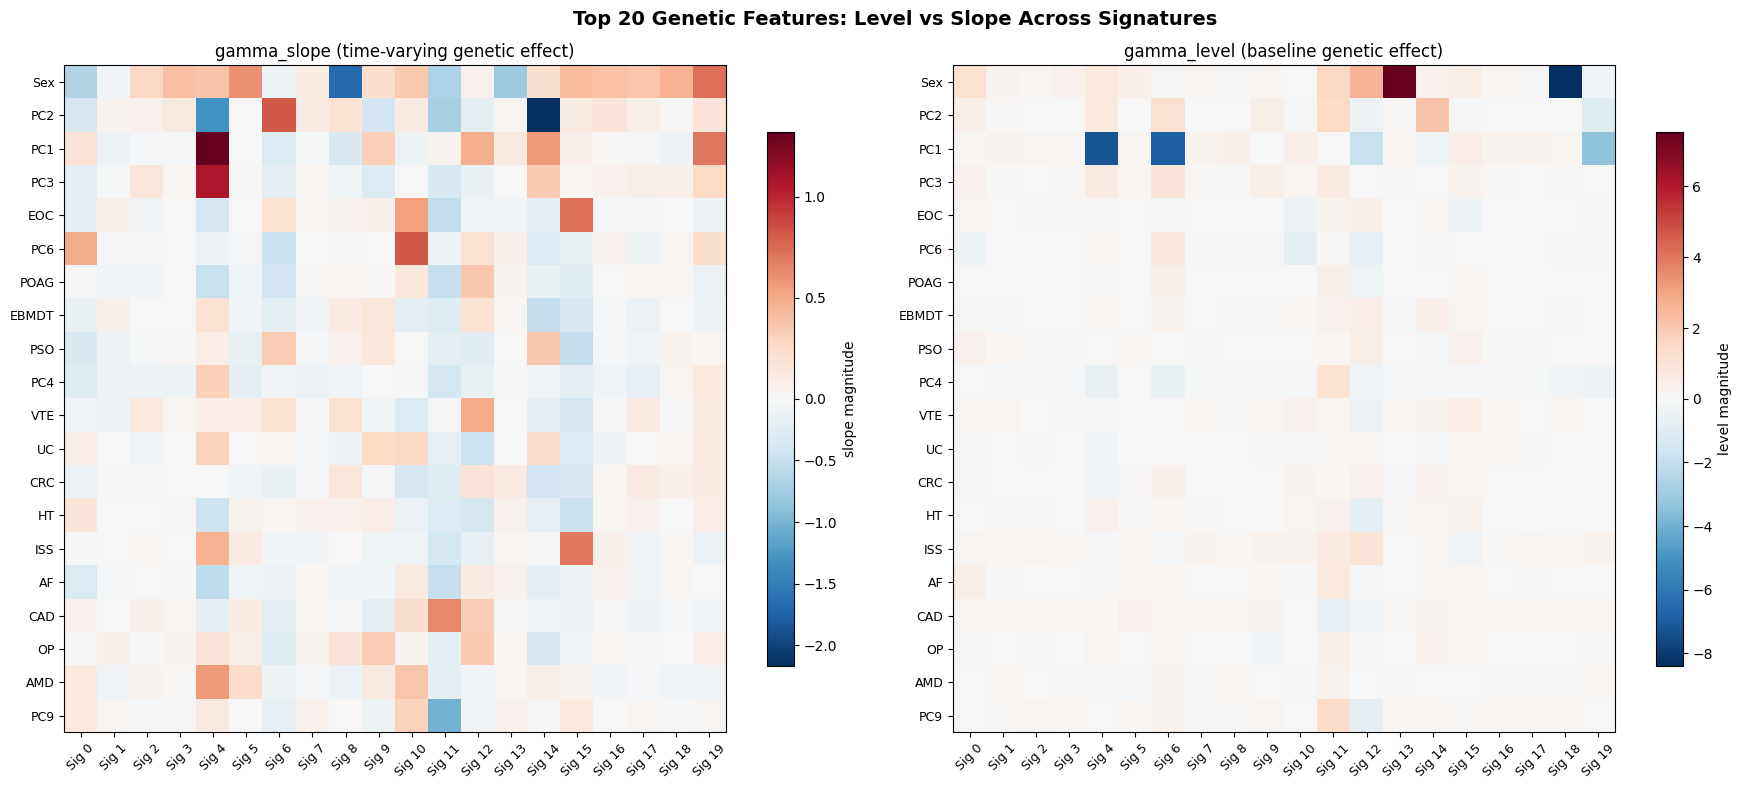

Saved: slope_heatmap.pdf


In [ ]:
# --- Plot 4: Genetic slope heatmap: which PRS x Signature combos have the strongest time effects ---
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

gs = model.gamma_slope.data.numpy()[:len(prs_names_full), :K]
gl = model.gamma_level.data.numpy()[:len(prs_names_full), :K]

# Sort features by total slope magnitude for a nice display
feature_importance = np.abs(gs).sum(axis=1)
sorted_idx = np.argsort(feature_importance)[::-1][:20]  # top 20 features

labels_sorted = [prs_names_full[i] for i in sorted_idx]
sig_labels = [f'Sig {k}' for k in range(K)]

import matplotlib.colors as mcolors

# Heatmap of slope magnitudes
im1 = axes[0].imshow(gs[sorted_idx], aspect='auto', cmap='RdBu_r',
                      norm=mcolors.TwoSlopeNorm(0))
axes[0].set_yticks(range(len(sorted_idx)))
axes[0].set_yticklabels(labels_sorted, fontsize=9)
axes[0].set_xticks(range(K))
axes[0].set_xticklabels(sig_labels, fontsize=9, rotation=45)
axes[0].set_title('gamma_slope (time-varying genetic effect)', fontsize=12)
plt.colorbar(im1, ax=axes[0], shrink=0.8, label='slope magnitude')

# Heatmap of level magnitudes
im2 = axes[1].imshow(gl[sorted_idx], aspect='auto', cmap='RdBu_r',
                      norm=mcolors.TwoSlopeNorm(0))
axes[1].set_yticks(range(len(sorted_idx)))
axes[1].set_yticklabels(labels_sorted, fontsize=9)
axes[1].set_xticks(range(K))
axes[1].set_xticklabels(sig_labels, fontsize=9, rotation=45)
axes[1].set_title('gamma_level (baseline genetic effect)', fontsize=12)
plt.colorbar(im2, ax=axes[1], shrink=0.8, label='level magnitude')

plt.suptitle('Top 20 Genetic Features: Level vs Slope Across Signatures',
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('/Users/sarahurbut/aladynoulli2/claudefile/slope_heatmap.pdf', dpi=300, bbox_inches='tight')
plt.show()
print('Saved: slope_heatmap.pdf')

In [ ]:
# --- Plot 5: Disease-level lambda trajectories: how genetic slopes reshape disease risk over time ---
with torch.no_grad():
    mean_lam_slope = model_slope_hold.get_mean_lambda()  # (N, K+1, T)
    mean_lam_noslope = model_noslope_hold.get_mean_lambda()  # (N, K+1, T)

# Get phi to see how signatures map to diseases
phi = model.phi.data  # or softmax of psi
if hasattr(phi, 'shape') and phi.shape[0] > 0:
    phi_np = phi.numpy()
else:
    phi_np = torch.softmax(model.psi.data, dim=0).numpy()

# Compute expected disease-level trajectories: lambda_disease(i,d,t) = sum_k phi(d,k) * lambda(i,k,t)
# lam: (N, K+1, T), phi: (D, K+1)
disease_lam_slope = np.einsum('nkt,dk->ndt', mean_lam_slope.numpy(), phi_np)    # (N, D, T)
disease_lam_noslope = np.einsum('nkt,dk->ndt', mean_lam_noslope.numpy(), phi_np) # (N, D, T)

# Find diseases most affected by slopes (largest mean absolute difference)
diff_by_disease = np.abs(disease_lam_slope - disease_lam_noslope).mean(axis=(0, 2))  # (D,)
top_diseases = np.argsort(diff_by_disease)[::-1][:6]

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
t_axis = np.arange(T)

for i, d_idx in enumerate(top_diseases):
    ax = axes[i // 3, i % 3]
    d_name = disease_names[d_idx] if d_idx < len(disease_names) else f'Disease {d_idx}'

    # Population average trajectory
    mean_with = disease_lam_slope[:, d_idx, :].mean(axis=0)
    mean_without = disease_lam_noslope[:, d_idx, :].mean(axis=0)

    # Also show spread (25th-75th percentile)
    q25_with = np.percentile(disease_lam_slope[:, d_idx, :], 25, axis=0)
    q75_with = np.percentile(disease_lam_slope[:, d_idx, :], 75, axis=0)
    q25_without = np.percentile(disease_lam_noslope[:, d_idx, :], 25, axis=0)
    q75_without = np.percentile(disease_lam_noslope[:, d_idx, :], 75, axis=0)

    ax.plot(t_axis, mean_with, color='#e74c3c', linewidth=2, label='With slopes')
    ax.fill_between(t_axis, q25_with, q75_with, color='#e74c3c', alpha=0.15)
    ax.plot(t_axis, mean_without, color='#3498db', linewidth=2, label='No slopes')
    ax.fill_between(t_axis, q25_without, q75_without, color='#3498db', alpha=0.15)

    ax.set_title(d_name, fontsize=12, fontweight='bold')
    ax.set_xlabel('Time index')
    ax.set_ylabel('Expected disease rate')
    ax.legend(fontsize=8)
    ax.grid(alpha=0.3)

plt.suptitle('Diseases Most Affected by Genetic Slopes\n(Mean +/- IQR across holdout patients)',
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('/Users/sarahurbut/aladynoulli2/claudefile/slope_disease_trajectories.pdf', dpi=300, bbox_inches='tight')
plt.show()
print('Saved: slope_disease_trajectories.pdf')

ValueError: operand has more dimensions than subscripts given in einstein sum, but no '...' ellipsis provided to broadcast the extra dimensions.

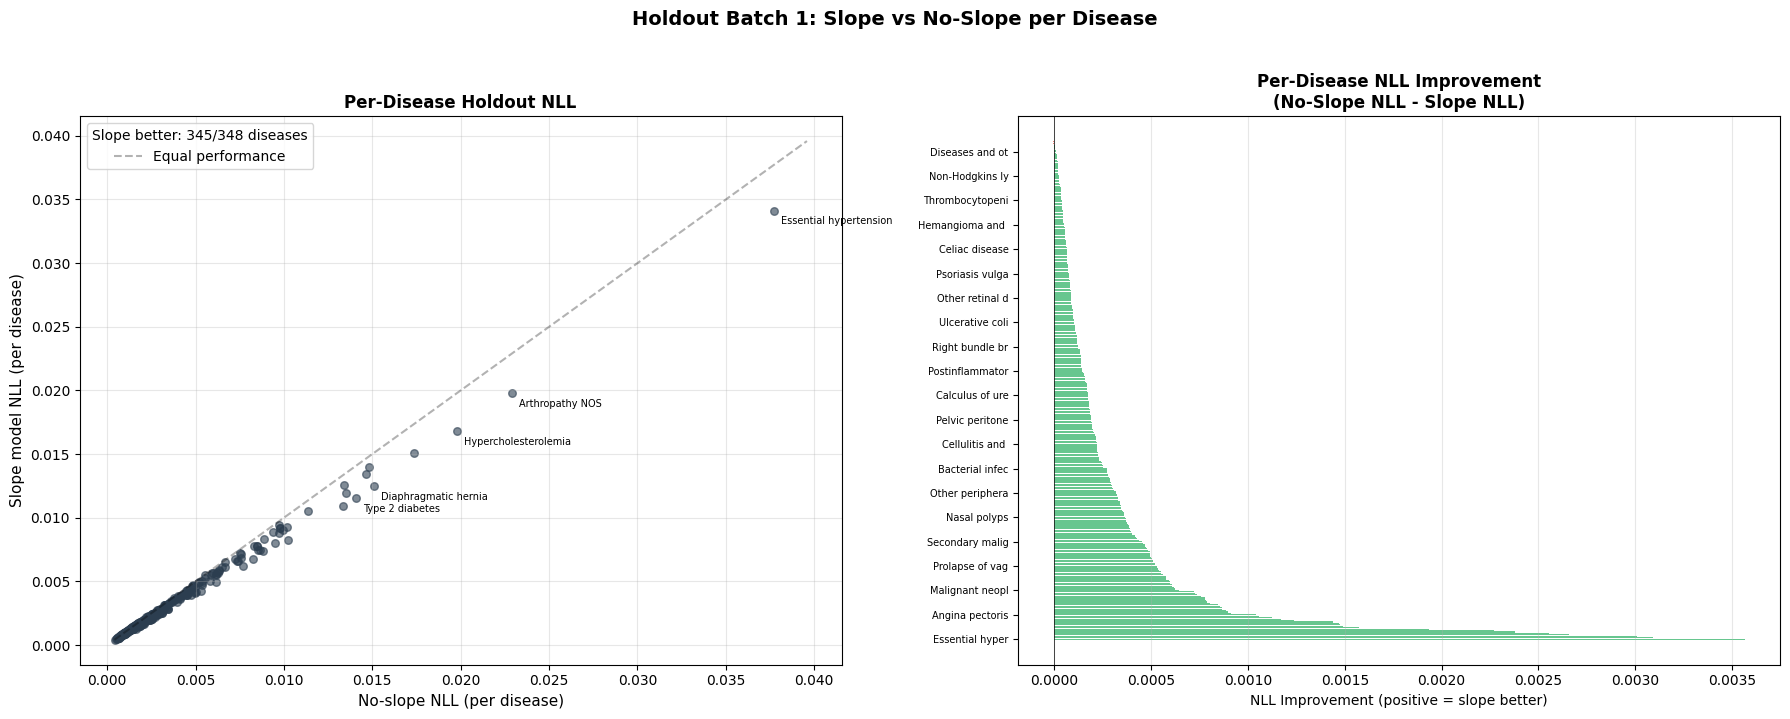

Saved: slope_per_disease_nll.pdf

Slope model better for 345/348 diseases
Mean improvement: 0.000309


In [ ]:
# --- Plot 6: Per-disease holdout NLL comparison ---
# Compare NLL at the individual disease level: slope vs no-slope

with torch.no_grad():
    # Get pi (predicted probabilities) from both models via forward()
    pi_slope, _, _ = model_slope_hold.forward()      # (N, D, T)
    pi_noslope, _, _ = model_noslope_hold.forward()   # (N, D, T)

# Compute per-disease NLL using same masking as the model's loss function
eps = 1e-8
E_tensor = torch.tensor(E_hold, dtype=torch.long)
E_expanded = E_tensor.unsqueeze(-1)  # (N, D, 1)
time_grid = torch.arange(T, dtype=torch.long).unsqueeze(0).unsqueeze(0)  # (1, 1, T)
mask_before = (time_grid < E_expanded).float()  # (N, D, T)
mask_at = (time_grid == E_expanded).float()      # (N, D, T)

per_disease_nll_slope = []
per_disease_nll_noslope = []
for d in range(D):
    y_d = Y_hold[:, d, :]
    mb_d = mask_before[:, d, :]
    ma_d = mask_at[:, d, :]

    pi_s = pi_slope[:, d, :].clamp(eps, 1 - eps)
    pi_ns = pi_noslope[:, d, :].clamp(eps, 1 - eps)

    # Censored (before event) + at event
    nll_s = (-torch.log(1 - pi_s) * mb_d
             - torch.log(pi_s) * ma_d * y_d
             - torch.log(1 - pi_s) * ma_d * (1 - y_d))
    nll_ns = (-torch.log(1 - pi_ns) * mb_d
              - torch.log(pi_ns) * ma_d * y_d
              - torch.log(1 - pi_ns) * ma_d * (1 - y_d))

    n_obs = (mb_d.sum() + ma_d.sum()).clamp(min=1)
    per_disease_nll_slope.append((nll_s.sum() / n_obs).item())
    per_disease_nll_noslope.append((nll_ns.sum() / n_obs).item())

per_disease_nll_slope = np.array(per_disease_nll_slope)
per_disease_nll_noslope = np.array(per_disease_nll_noslope)
improvement = per_disease_nll_noslope - per_disease_nll_slope

fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# Scatter: per-disease NLL
ax = axes[0]
ax.scatter(per_disease_nll_noslope, per_disease_nll_slope, s=30, alpha=0.6, c='#2c3e50')
lims = [min(per_disease_nll_noslope.min(), per_disease_nll_slope.min()) * 0.95,
        max(per_disease_nll_noslope.max(), per_disease_nll_slope.max()) * 1.05]
ax.plot(lims, lims, 'k--', alpha=0.3, label='Equal performance')
ax.set_xlabel('No-slope NLL (per disease)', fontsize=11)
ax.set_ylabel('Slope model NLL (per disease)', fontsize=11)
ax.set_title('Per-Disease Holdout NLL', fontsize=12, fontweight='bold')
n_better = (improvement > 0).sum()
ax.legend(title=f'Slope better: {n_better}/{D} diseases')
ax.grid(alpha=0.3)
# Label top improved diseases
top_improved = np.argsort(improvement)[::-1][:5]
for idx in top_improved:
    name = disease_names[idx] if idx < len(disease_names) else f'D{idx}'
    ax.annotate(name, (per_disease_nll_noslope[idx], per_disease_nll_slope[idx]),
               fontsize=7, xytext=(5, -10), textcoords='offset points')

# Bar chart: improvement by disease (sorted)
ax = axes[1]
sorted_imp = np.argsort(improvement)[::-1]
colors = ['#27ae60' if improvement[i] > 0 else '#e74c3c' for i in sorted_imp]
bar_names = [disease_names[i][:15] if i < len(disease_names) else f'D{i}' for i in sorted_imp]
ax.barh(range(len(sorted_imp)), improvement[sorted_imp], color=colors, alpha=0.7)
ax.set_yticks(range(0, len(sorted_imp), max(1, len(sorted_imp)//20)))
ax.set_yticklabels([bar_names[i] for i in range(0, len(sorted_imp), max(1, len(sorted_imp)//20))], fontsize=7)
ax.axvline(0, color='k', linewidth=0.5)
ax.set_xlabel('NLL Improvement (positive = slope better)')
ax.set_title('Per-Disease NLL Improvement\n(No-Slope NLL - Slope NLL)', fontsize=12, fontweight='bold')
ax.grid(alpha=0.3, axis='x')

plt.suptitle(f'Holdout Batch {HOLDOUT_BATCH}: Slope vs No-Slope per Disease', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('/Users/sarahurbut/aladynoulli2/claudefile/slope_per_disease_nll.pdf', dpi=300, bbox_inches='tight')
plt.show()
print(f'Saved: slope_per_disease_nll.pdf')
print(f'\nSlope model better for {n_better}/{D} diseases')
print(f'Mean improvement: {improvement.mean():.6f}')

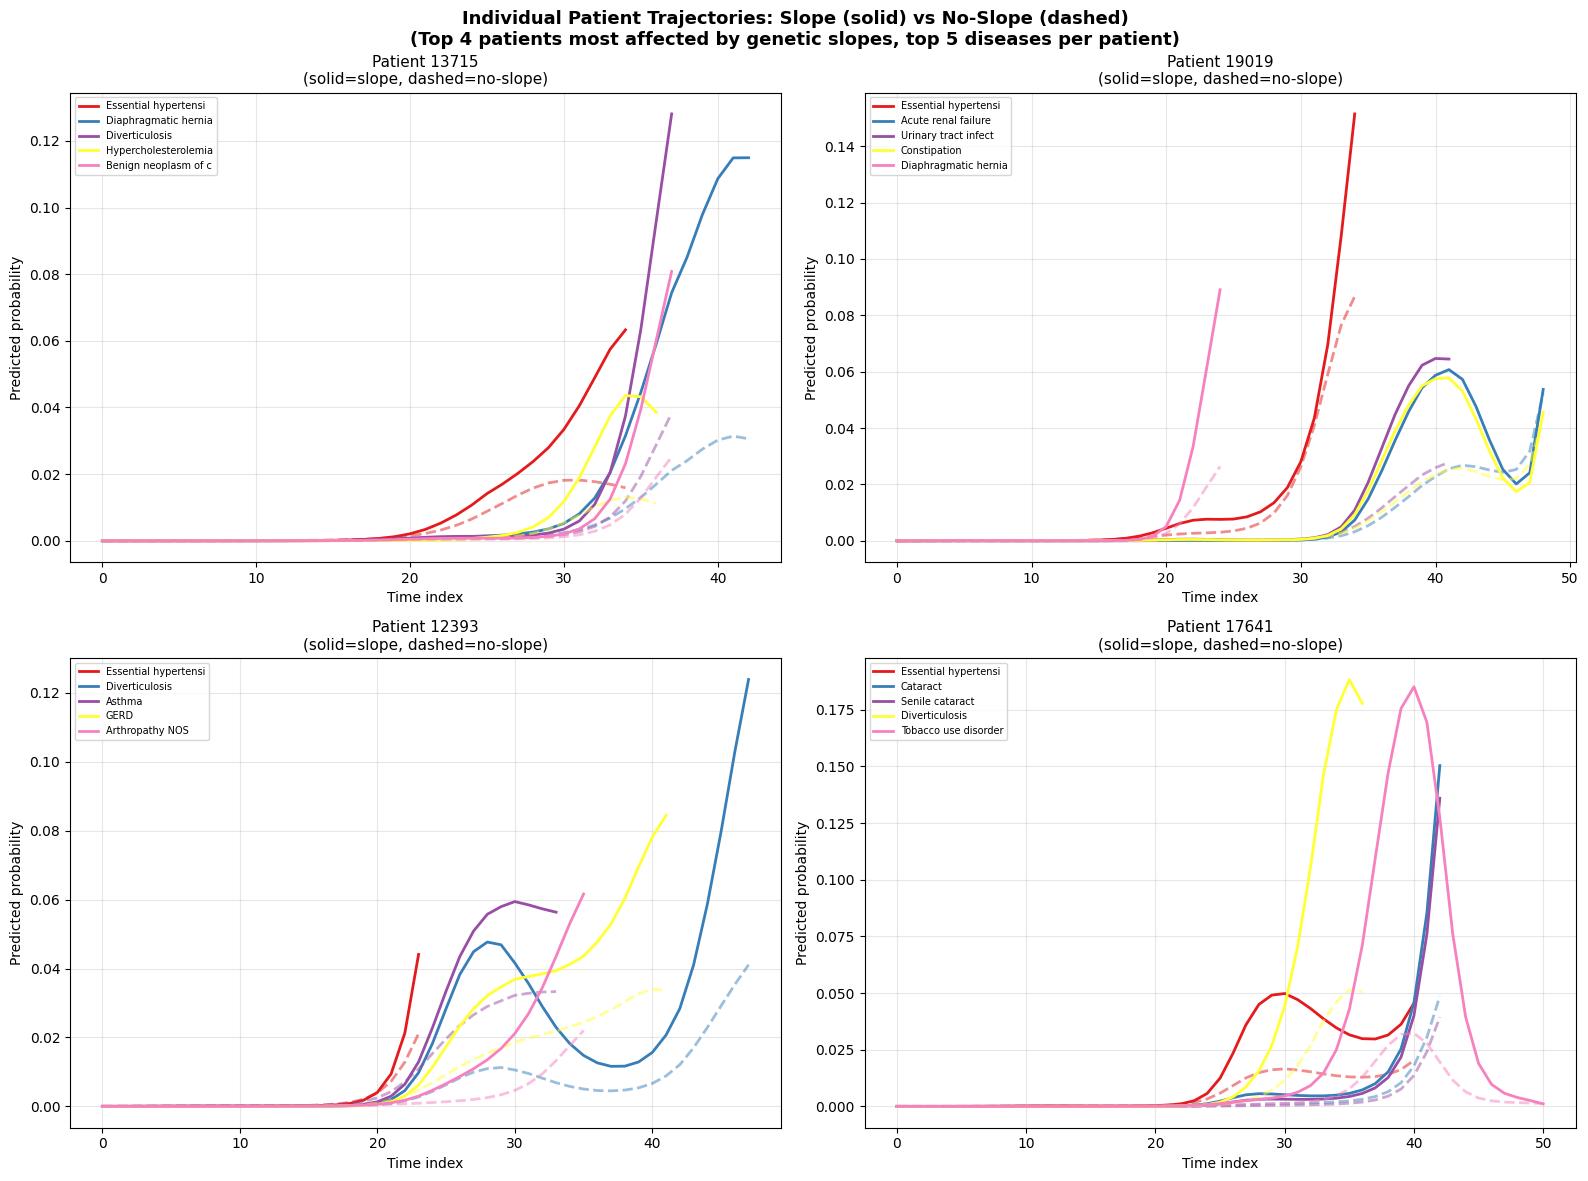

Saved: slope_individual_trajectories.pdf


In [ ]:
# --- Plot 7: Individual patient trajectories: slope vs no-slope predictions ---
# Find a patient who is most affected by genetic slopes
with torch.no_grad():
    pi_s, _, _ = model_slope_hold.forward()
    pi_ns, _, _ = model_noslope_hold.forward()

# Per-patient total absolute difference across all diseases/time
patient_diff = (pi_s - pi_ns).abs().sum(dim=(1, 2))
top_patients = patient_diff.argsort(descending=True)[:4].numpy()

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
t_axis = np.arange(T)

for ax_i, pat_idx in enumerate(top_patients):
    ax = axes[ax_i // 2, ax_i % 2]

    # Find top 5 diseases for this patient where slope matters most
    d_diff = (pi_s[pat_idx] - pi_ns[pat_idx]).abs().sum(dim=1)  # (D,)
    top_d = d_diff.argsort(descending=True)[:5].numpy()

    cmap = plt.cm.Set1
    for j, d_idx in enumerate(top_d):
        d_name = disease_names[d_idx][:20] if d_idx < len(disease_names) else f'D{d_idx}'
        color = cmap(j / 5)

        # Event time for this patient/disease
        et = E_hold[pat_idx, d_idx] if hasattr(E_hold, '__getitem__') else int(E_hold[pat_idx, d_idx])

        ax.plot(t_axis[:et], pi_s[pat_idx, d_idx, :et].numpy(),
                color=color, linewidth=2, label=f'{d_name}')
        ax.plot(t_axis[:et], pi_ns[pat_idx, d_idx, :et].numpy(),
                color=color, linewidth=2, linestyle='--', alpha=0.5)

    ax.set_xlabel('Time index')
    ax.set_ylabel('Predicted probability')
    ax.set_title(f'Patient {h_start + pat_idx}\n(solid=slope, dashed=no-slope)', fontsize=11)
    ax.legend(fontsize=7, loc='upper left')
    ax.grid(alpha=0.3)

plt.suptitle('Individual Patient Trajectories: Slope (solid) vs No-Slope (dashed)\n'
             '(Top 4 patients most affected by genetic slopes, top 5 diseases per patient)',
             fontsize=13, fontweight='bold')
plt.tight_layout()
plt.savefig('/Users/sarahurbut/aladynoulli2/claudefile/slope_individual_trajectories.pdf', dpi=300, bbox_inches='tight')
plt.show()
print('Saved: slope_individual_trajectories.pdf')

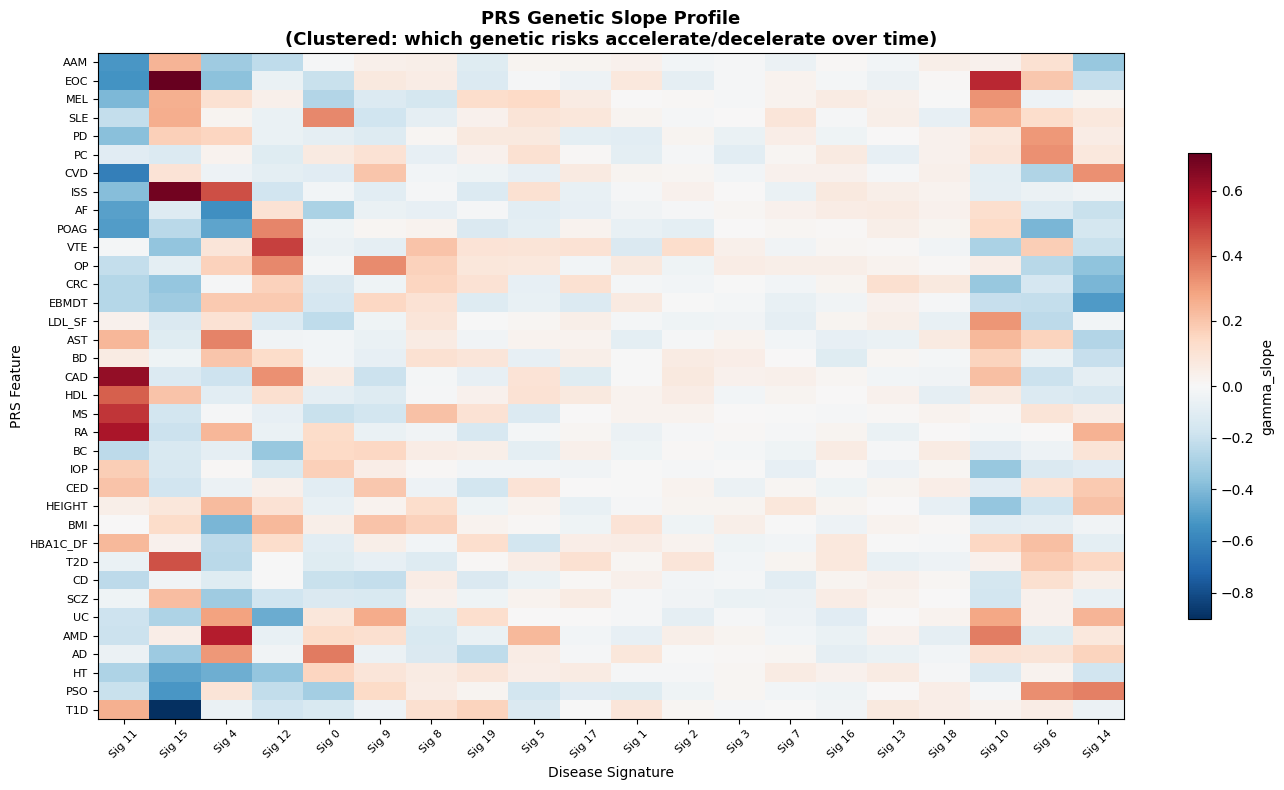

Saved: slope_prs_clustered_heatmap.pdf


In [ ]:
# --- Plot 8: PRS-specific genetic slope profiles across signatures ---
# Which PRS scores accelerate (positive slope) vs decelerate (negative slope) across which signatures?

gs = model.gamma_slope.data.numpy()
prs_df_plot = pd.read_csv('/Users/sarahurbut/aladynoulli2/prs_names.csv', header=None)
prs_names_short = list(prs_df_plot.iloc[:, 0].values)  # 36 PRS abbreviations

fig, ax = plt.subplots(figsize=(14, 8))

# Just PRS features (first 36), across all K signatures
gs_prs = gs[:36, :K]

# Cluster rows and columns for a nice display
from scipy.cluster.hierarchy import linkage, leaves_list

row_link = linkage(gs_prs, method='ward')
col_link = linkage(gs_prs.T, method='ward')
row_order = leaves_list(row_link)
col_order = leaves_list(col_link)

gs_ordered = gs_prs[row_order][:, col_order]
labels_ordered = [prs_names_short[i] for i in row_order]
sig_labels_ordered = [f'Sig {col_order[j]}' for j in range(K)]

import matplotlib.colors as mcolors
im = ax.imshow(gs_ordered, aspect='auto', cmap='RdBu_r',
               norm=mcolors.TwoSlopeNorm(0), interpolation='nearest')
ax.set_yticks(range(36))
ax.set_yticklabels(labels_ordered, fontsize=8)
ax.set_xticks(range(K))
ax.set_xticklabels(sig_labels_ordered, fontsize=8, rotation=45)
plt.colorbar(im, ax=ax, shrink=0.7, label='gamma_slope')
ax.set_title('PRS Genetic Slope Profile\n(Clustered: which genetic risks accelerate/decelerate over time)',
             fontsize=13, fontweight='bold')
ax.set_xlabel('Disease Signature')
ax.set_ylabel('PRS Feature')

plt.tight_layout()
plt.savefig('/Users/sarahurbut/aladynoulli2/claudefile/slope_prs_clustered_heatmap.pdf', dpi=300, bbox_inches='tight')
plt.show()
print('Saved: slope_prs_clustered_heatmap.pdf')

In [ ]:
# --- Summary statistics ---
print('=' * 70)
print('GENETIC SLOPE MODEL: SUMMARY')
print('=' * 70)

gs = model.gamma_slope.data.numpy()
gl = model.gamma_level.data.numpy()

print(f'\n--- Magnitude ---')
print(f'  |gamma_slope| mean: {np.abs(gs).mean():.5f}')
print(f'  |gamma_level| mean: {np.abs(gl).mean():.5f}')
print(f'  Ratio (slope/level): {np.abs(gs).mean() / np.abs(gl).mean():.4f}')

print(f'\n--- Holdout NLL (batch {HOLDOUT_BATCH}, {N_h} patients) ---')
print(f'  With slopes:    {slope_nlls[-1]:.4f}')
print(f'  Without slopes: {noslope_nlls[-1]:.4f}')
print(f'  Improvement:    {noslope_nlls[-1] - slope_nlls[-1]:.4f} '
      f'({(noslope_nlls[-1] - slope_nlls[-1])/abs(noslope_nlls[-1])*100:.2f}%)')

print(f'\n--- Per-disease holdout NLL ---')
improvement = np.array(per_disease_nll_noslope) - np.array(per_disease_nll_slope)
n_better = (improvement > 0).sum()
print(f'  Slope better in {n_better}/{D} diseases')
print(f'  Mean improvement: {improvement.mean():.6f}')
print(f'  Max improvement:  {improvement.max():.6f} '
      f'({disease_names[improvement.argmax()]})')
print(f'  Max worsening:    {improvement.min():.6f} '
      f'({disease_names[improvement.argmin()]})')

print(f'\n--- Top 5 diseases improved by slopes ---')
for idx in np.argsort(improvement)[::-1][:5]:
    print(f'  {disease_names[idx]:30s}  NLL improvement: {improvement[idx]:.6f}')

print(f'\n--- Top 5 diseases worsened by slopes ---')
for idx in np.argsort(improvement)[:5]:
    print(f'  {disease_names[idx]:30s}  NLL worsening: {improvement[idx]:.6f}')

print(f'\n{"="*70}')

GENETIC SLOPE MODEL: SUMMARY

--- Magnitude ---
  |gamma_slope| mean: 0.12028
  |gamma_level| mean: 0.18069
  Ratio (slope/level): 0.6656

--- Holdout NLL (batch 1, 10000 patients) ---
  With slopes:    43.9532
  Without slopes: 48.4860
  Improvement:    4.5328 (9.35%)

--- Per-disease holdout NLL ---
  Slope better in 345/348 diseases
  Mean improvement: 0.000309
  Max improvement:  0.003569 (Essential hypertension)
  Max worsening:    -0.000009 (Other disorders of prostate)

--- Top 5 diseases improved by slopes ---
  Essential hypertension          NLL improvement: 0.003569
  Arthropathy NOS                 NLL improvement: 0.003094
  Hypercholesterolemia            NLL improvement: 0.003007
  Diaphragmatic hernia            NLL improvement: 0.002657
  Type 2 diabetes                 NLL improvement: 0.002556

--- Top 5 diseases worsened by slopes ---
  Other disorders of prostate     NLL worsening: -0.000009
  Chronic prostatitis             NLL worsening: -0.000006
  Alcoholic liv